# A review of basic concepts in the field of Machine Learning, Artificial Intelligence and Data Mining

## First, we define the classification problem in the context of supervised learning:
### Given that X is a space of feature vectors and C a set of classes, we assume there is a function c - which is generally unknown - that enables the error-free classification of 
### c : X &rarr; C
### Generally, we only know a subset of a samples in the form of:
### D = {(x_1, c(x_1)), (x_2, c(x_2)),...,(x_n, c(x_n))} ⊆ X x C
### Where X x C represents the Cartesian product, all possible combinations of a feature vector with a class.
### The construction of this function c is the soltuion of the classification problem.

## In a similar manner, the solution of a regression problem simply redefines C, which instead corresponds to Y ⊆ R^n for this context.

In [1]:
import numpy as np

np.random.seed(42)

fString = open("diagnosis.data", "r", encoding="utf-16")
fFloat = open("diagnosis.csv", "w")
for line in fString:
    line = line.replace(",", ".")
    line = line.replace("\t", ",")
    line = line.replace("yes", "1")
    line = line.replace("no", "0")
    line = line.replace("\r\n", "\n")
    fFloat.write(line)
fString.close()
fFloat.close()

fFloat = open("diagnosis.csv", "r")
dataset = np.loadtxt(fFloat, delimiter=",")
fFloat.close()

In [2]:
X = dataset[:,1:6]
Y = dataset[:,6]
allData = np.arange(0, X.shape[0])
iTesting = np.random.choice(X.shape[0], int(X.shape[0]*0.2), replace=False)
iTraining = np.delete(allData, iTesting)
dataRecords = len(iTraining)
XTrain = X[iTraining, :]
YTrain = Y[iTraining]

# Naive Bayes Classifier: Probability estimation using the Assumption of Feature Indepence

$$
P(i|x) = \frac{\prod_{k=1}^{m} P(x^{(k)}|i) \cdot P(i)}{\sum_{j=1}^{N} P(j) \cdot \prod_{k=1}^m P(x^{(k)}|j)}
$$

In [3]:
PIX = np.zeros( (2, XTrain.shape[1],2))
# Matrix of feature shapes (5)
PI = np.zeros(2)
# for k in range number of features (m)
for k in range(X.shape[1]):
    
    # Generally PIX[l,k,i], where x^k=l = P(x^k=l|i)
    
    # Number of samples where feature k is True AND the result is also true
    # Equal to Sum(x^k|i)
    PIX[0,k,0] = np.sum(np.logical_and(XTrain[:,k], YTrain))
    # Number of samples where feature k is False AND the result is true
    # Equal to Sum(i)-Sum(x^k|i) 
    PIX[0,k,1] = np.sum(np.logical_and(np.logical_not(XTrain[:,k]), YTrain))
    # # Number of samples where feature k is True AND the result is False
    # Equal to Sum(x^k|!i)
    PIX[1,k,0] = np.sum(np.logical_and(XTrain[:,k], np.logical_not(YTrain)))
    # # Number of samples where feature k is False AND the result is also False
    # Equal to Sum(!i) - Sum(x^k|!i)
    PIX[1,k,1] = np.sum(np.logical_not(np.logical_or(XTrain[:,k], YTrain)))
# Sum(i)
PI[0] = np.sum(YTrain)
# Sum(!i)
PI[1] = dataRecords-PI[0]

In [25]:
# Accounting for missing combinations, such as PIX[0,2,1] by adding one distributed occurence to all entries
PIX = (PIX+1/2) / (dataRecords+1)
# normalizing through datarecords plus added occurence
PI = PI / dataRecords

In [5]:
np.arange(XTrain.shape[1])

array([0, 1, 2, 3, 4])

In [6]:
def predictNaiveBayesNominal(l):
    P = np.zeros_like(PI)
    # range of all features
    x = np.arange(XTrain.shape[1])
    for j in range(len(PI)):
        # product of P(x^k=l|i) for features with given values for class value j
        # Note that this is fixed for the numerator, but always summed up for the denominator, regardless of i
        P[j] = np.prod(PIX[j, x, l])*PI[j]
        #      P(x^(k)|j) * P(j) in formula above (without the summation)
    
    # Applying summation for the denominator, as just calculated
    denominator = np.sum(P)
    # Dividing the respective class-specific products by the unfixed probability of f(x)
    P = P/denominator
    # choose class with maximum probability
    chosenClass = np.argmax(P)
    return chosenClass

In [7]:
correct = np.zeros(2)
incorrect = np.zeros(2)

XTest = X[iTesting,:]
YTest = Y[iTesting]

for i in range(XTest.shape[0]):
    Class = predictNaiveBayesNominal(XTest[i,:].astype(int))
    if(Class == YTest[i]):
        correct[Class] = correct[Class] + 1
    else:
        incorrect[Class] = incorrect[Class] + 1

In [8]:
print(correct)
print(incorrect)

[ 7. 12.]
[0. 5.]


## Introducing Cardinal Scale feature: Temperature

In [9]:
# We assume a gaussian normal distribution, which we would like to confirm using a basic histogram

T = dataset[:,0]
trueIndex = np.flatnonzero(YTrain==1)
falseIndex = np.flatnonzero(YTrain==0)
# mu = sum_t=0_to_s (T/n)
muApproxTrue = np.sum(T[trueIndex])/trueIndex.shape[0]
# sigma^2 = sum_t=0_to_s (T-mu)^2/n-1 (using Bessel's correction)
sgApproxTrue = np.sum( (T[trueIndex]-muApproxTrue)**2) / (trueIndex.shape[0] -1)
# Same for the distribution of healthy patients
muApproxFalse = np.sum(T[falseIndex])/falseIndex.shape[0]
sgApproxFalse = np.sum( (T[falseIndex]-muApproxFalse)**2 ) / (falseIndex.shape[0] - 1)

### Applying standard gaussian distribution
$$
y = \frac{e^{-0.5 \left(\frac{x - \mu}{\sigma}\right)^2}}{\sigma \sqrt{2\pi}}
$$

In [10]:
def GaussianDistribution(x, mu, sigma):
    # (e^-1/2* ((x-mu)/sig)^2)/(sigma*sqrt(2*pi)) 
    y = np.exp(-0.5*( (x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))
    return y

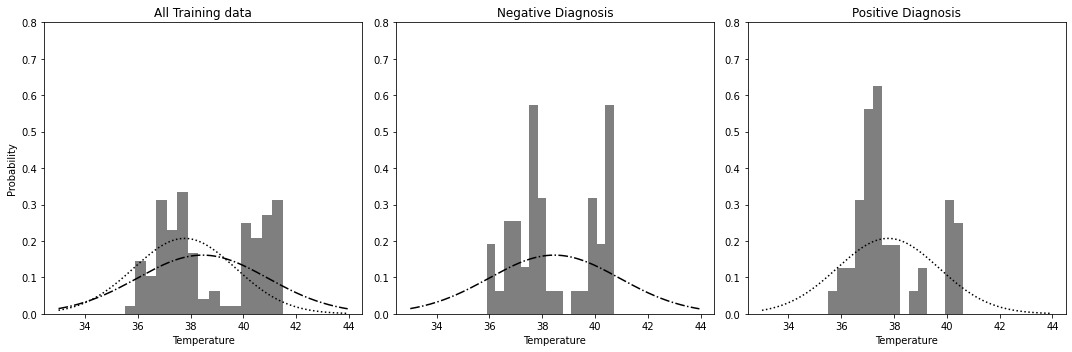

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5)) 
ax = fig.add_subplot(131)
ax.hist(T[:],15,density=1, facecolor='k', alpha=0.5)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
Tplot = np.arange(33,44,0.05)
ax.plot(Tplot, GaussianDistribution(Tplot, muApproxTrue, sgApproxTrue), 'k:')
ax.plot(Tplot, GaussianDistribution(Tplot, muApproxFalse, sgApproxFalse), 'k-.')
ax.set_ylim([0,0.8])
ax.set_title('All Training data')
ax = fig.add_subplot(132)
ax.hist(T[falseIndex],15,density=1, facecolor='k',alpha=0.5)
ax.set_xlabel('Temperature')
ax.plot(Tplot, GaussianDistribution(Tplot, muApproxFalse, sgApproxFalse), 'k-.')
ax.set_ylim([0,0.8])
ax.set_title('Negative Diagnosis')
ax = fig.add_subplot(133)
ax.hist(T[trueIndex],15,density=1, facecolor='k',alpha=0.5)
ax.set_xlabel('Temperature')
ax.plot(Tplot, GaussianDistribution(Tplot, muApproxTrue,sgApproxTrue), 'k:')
ax.set_ylim([0,0.8])
ax.set_title('Positive Diagnosis')
plt.tight_layout()
plt.show(block=False)

In [32]:
def predictNaiveBayesMixed(x, T, muTrue, sigmaTrue, muFalse, sigmaFalse):
    P = np.zeros_like(PI)
    allofthem = np.arange(XTrain.shape[1])
    P[0] = np.prod(PIX[0, allofthem, x])*PI[0]
    P[1] = np.prod(PIX[1, allofthem, x])*PI[1]
    P[0] = P[0]*GaussianDistribution(T, muFalse, sigmaFalse)
    P[1] = P[1]*GaussianDistribution(T, muTrue, sigmaTrue)
    chosenClass = np.argmax(P)
    return chosenClass

In [33]:
XTest = X[iTesting, :]
YTest = Y[iTesting]
correct = np.zeros(2)
incorrect = np.zeros(2)
TTest = T[iTesting]
def TestNaiveBayesMixed(muTrue, sigmaTrue, muFalse, sigmaFalse):
    correct = np.zeros(2)
    incorrect = np.zeros(2)
    for i in range(XTest.shape[0]):
        Class = predictNaiveBayesMixed(XTest[i,:].astype(int), TTest[i], muTrue, sigmaTrue, muFalse, sigmaFalse)
        if Class == YTest[i]:
            correct[Class] = correct[Class] + 1
        else:
            incorrect[Class] = incorrect[Class] + 1
    return (correct, incorrect)

(correct, incorrect) = TestNaiveBayesMixed(muApproxTrue, sgApproxTrue, muApproxFalse, sgApproxFalse)

In [14]:
print(correct)
print(incorrect)

[ 7. 12.]
[0. 5.]


In [15]:
kfold = 5
allCorrect = 0
allInCorrect = 0
for holdout in range(5):
    
    ## Training
    
    PIX = np.zeros( (2, XTrain.shape[1],2))
    # Matrix of feature shapes (5)
    PI = np.zeros(2)
    # for k in range number of features (m)
    for k in range(X.shape[1]):

        # Generally PIX[l,k,i], where x^k=l = P(x^k=l|i)

        # Number of samples where feature k is True AND the result is also true
        # Equal to Sum(x^k|i)
        PIX[0,k,0] = np.sum(np.logical_and(XTrain[:,k], YTrain))
        # Number of samples where feature k is False AND the result is true
        # Equal to Sum(i)-Sum(x^k|i) 
        PIX[0,k,1] = np.sum(np.logical_and(np.logical_not(XTrain[:,k]), YTrain))
        # # Number of samples where feature k is True AND the result is False
        # Equal to Sum(x^k|!i)
        PIX[1,k,0] = np.sum(np.logical_and(XTrain[:,k], np.logical_not(YTrain)))
        # # Number of samples where feature k is False AND the result is also False
        # Equal to Sum(!i) - Sum(x^k|!i)
        PIX[1,k,1] = np.sum(np.logical_not(np.logical_or(XTrain[:,k], YTrain)))
    # Sum(i)
    PI[0] = np.sum(YTrain)
    # Sum(!i)
    PI[1] = dataRecords-PI[0]
    
    ## Testing 
    
    correct = np.zeros(2)
    incorrect = np.zeros(2)
    
    XTest = X[[x for x in allData if x not in range(holdout*(len(allData)//kfold),(holdout+1)*(len(allData)//kfold))],:]
    YTest = Y[[x for x in allData if x not in range(holdout*(len(allData)//kfold),(holdout+1)*(len(allData)//kfold))]]

    for i in range(XTest.shape[0]):
        Class = predictNaiveBayesNominal(XTest[i,:].astype(int))
        if(Class == YTest[i]):
            correct[Class] = correct[Class] + 1
        else:
            incorrect[Class] = incorrect[Class] + 1
    allCorrect += sum(correct)
    allInCorrect +=sum(incorrect)
    
print(f'Average accuracy over {kfold}-fold cross validation: {allCorrect/(allCorrect+allInCorrect)}')


Average accuracy over 5-fold cross validation: 0.825


In [17]:
T[iTesting]

array([37.5, 37.6, 36. , 37.9, 37. , 38.5, 40. , 36.6, 37.5, 41.1, 36.9,
       38.1, 36.6, 37.3, 40.6, 40.6, 41.1, 35.5, 40.5, 41. , 38.7, 37.6,
       37.2, 40. ])